# Facial Expression Classification

The notebook aims to compare between three modelsin facial classification, and select the best among them to deploy it in a GUI application to detect faces and classify emotions.

The used dataset is Emotion FER dataset, published in 2013 under the name of <b>"Challenges in Representation Learning: A report on three machine learning contests" </b> by I Goodfellow, Y. Bengio et al. - arXiv 2013.

The dataset consists of 35887 images for 7 basic emotions which are: Anger, Disgust, Fear, Happiness, Sadness, Surprise and Neutral.

The Notebook aims to explore different models and evaluate their models. As well it will explore the effect of data balancing and perioritizing the difficult examples in training.
 

## 0. Importing Libraries, Setting the Style of the Plots

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils import tensorboard

import torchvision
from torchvision import transforms

from IPython.display import clear_output
import IPython

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

C:\Users\Hussein\anaconda3\envs\pytorch_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


C:\Users\Hussein\anaconda3\envs\pytorch_venv\lib\site-packages\torch\cuda\memory.py:384: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [4]:
torch.cuda.mem_get_info()
torch.manual_seed(10)

In [5]:
plt.style.use('seaborn-whitegrid')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

--------------------------------------------

## 1. Data Exploration

In this section, the data frame will be explored. The exploration process will include data types of every series in the data frame, exploring the balance of the dataset as well as its subdivisions (Training, public test and private test), and visualizing samples of the seven emotions included in the dataset.

In [6]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

### 1.1. Basic Data types for every column in the dataframe

In [7]:
data = pd.read_csv('./data/icml_face_data.csv')

In [8]:
print(f'shape of dataframe is {data.shape}')
print(data.columns)

shape of dataframe is (35887, 3)
Index(['emotion', ' Usage', ' pixels'], dtype='object')


In [9]:
for column in data.columns:
    if column != ' pixels':
        print(f'The column {column} has a length {data[column].count()} with a datatype {data[column].dtype}')
        print(f'The distribution of its elements is \n{data[column].value_counts()}\n')

The column emotion has a length 35887 with a datatype int64
The distribution of its elements is 
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

The column  Usage has a length 35887 with a datatype object
The distribution of its elements is 
Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64



In [10]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [11]:
emotion_distribution = dict(data['emotion'].value_counts())
for item in emotion_distribution:
    print(f'count of {emotions[item]} images = {emotion_distribution[item]}')

count of Happy images = 8989
count of Neutral images = 6198
count of Sad images = 6077
count of Fear images = 5121
count of Angry images = 4953
count of Surprise images = 4002
count of Disgust images = 547


In [12]:
labels = []
counts = []
emo = []
for emotion, label in emotions.items():
    emo.append(emotion)
    labels.append(label)
    counts.append(emotion_distribution[emotion])
    
print(emo)
print(labels)
print(counts)

[0, 1, 2, 3, 4, 5, 6]
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
[4953, 547, 5121, 8989, 6077, 4002, 6198]


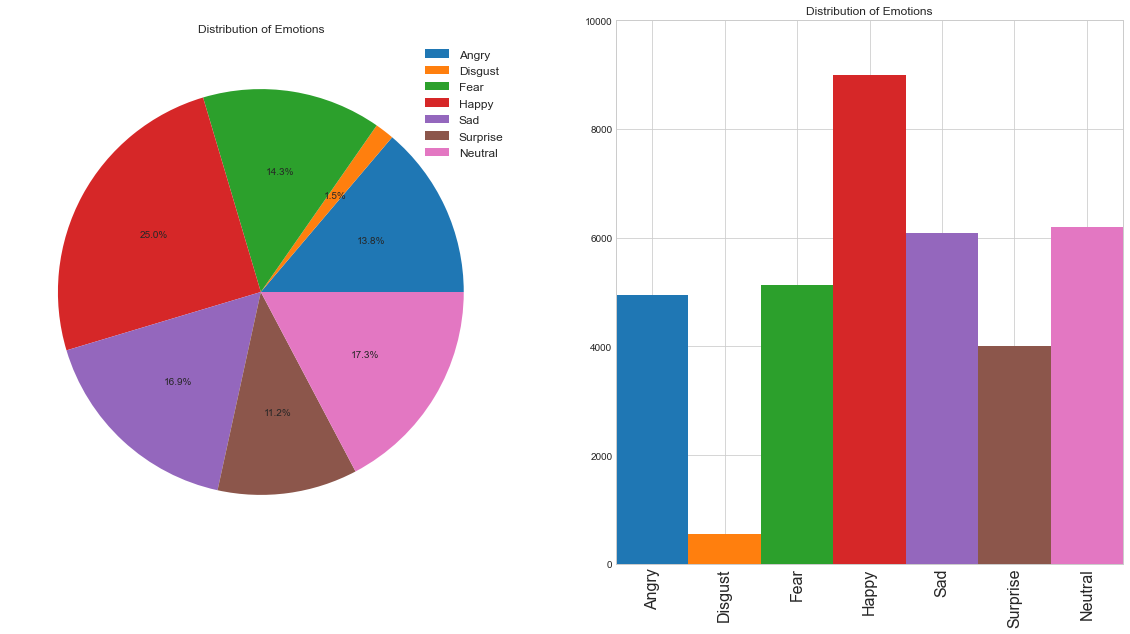

In [13]:
fig = plt.figure(figsize=(20, 10))

ax_0 = fig.add_subplot(1, 2, 1)
ax_0.pie(counts, colors = colors[0:len(counts)], autopct='%1.1f%%')
ax_0.set(title='Distribution of Emotions')
ax_0.legend(labels, prop={"size":12})

ax_1 = fig.add_subplot(1, 2, 2)
ax_1.bar(labels, counts, width= 1, color = colors[0:len(counts)])
ax_1.set(title='Distribution of Emotions', xlim=(-0.5, 6.5), ylim=(0, 10000))
ax_1.tick_params(axis='x', labelrotation=90, labelsize=16)
plt.show()

-----------------------------------------------

## 2. Dataset Class & Data Visualization

### 2.1. Dataset Division into Training, Dev and Test Sets

Dataset class will be constructed and applied to random transformations including Flipping and random rotations

In [14]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, Training='Training', transform=None, target_transform=None):        
        self.transform = transform
        self.target_transform = target_transform
        
        self.img_dir = os.path.join(img_dir, 'icml_face_data.csv')
        self.file = pd.read_csv(self.img_dir)
        self.file = self.file[self.file[' Usage'] == Training]
        
    def __getitem__(self, index):
        item = self.file.iloc[index]
        y = item['emotion']
        x = np.reshape(np.array(list(map(int, item[' pixels'].split())), dtype=np.float32), (48, 48, 1))
        
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
            
        return x, y
        
    def __len__(self):
        return len(self.file['emotion'])

### 2.2. Visualizing Data before Transformation

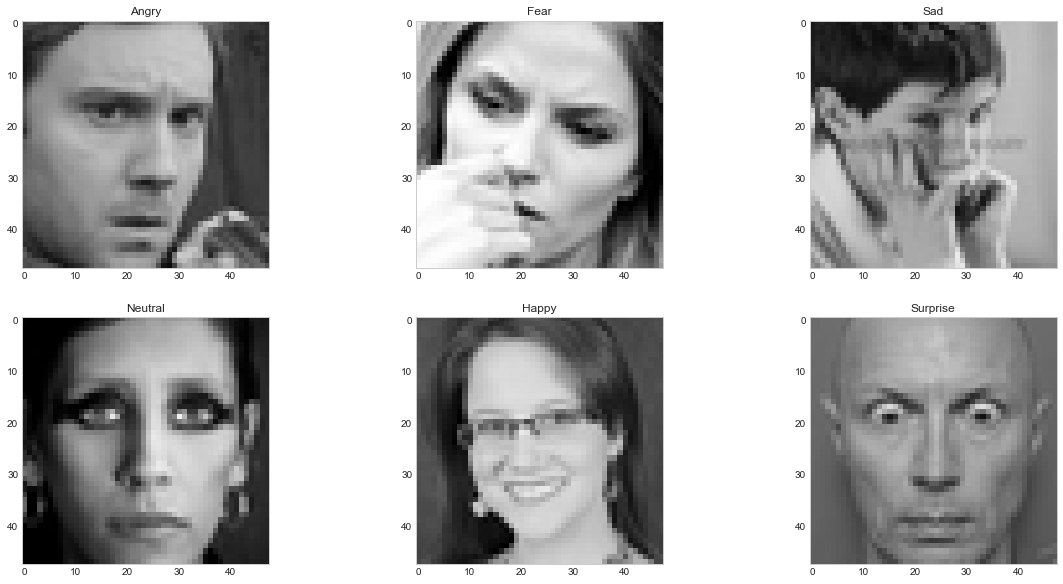

In [15]:
training_data = ImageDataset(img_dir='./data', Training='Training', transform=None)
fig = plt.figure(figsize=(20, 10))
showed = []
counter = 0
for i in range(len(training_data)):
    if len(showed)>=6:
        break
    if training_data[i][1] not in showed:
        ax = fig.add_subplot(2, 3, counter+1)
        ax.imshow(transforms.ToPILImage()(training_data[i][0].astype(int)))
        ax.set_title(emotions[training_data[i][1]])
        plt.grid(False)
        showed.append(training_data[i][1])
        counter+=1
        
plt.show()

------------------------------------------------------------------------------------------------------

## 3. Model Architecture Optimization

In this Notebook, a Convnet model will be tested to achieve a convenient performance for deployement.
The used model will be a classical CNN with VGG style-architecture, with a dynamic dropout system based on the number of epochs and the difference between the training and validation accuracy.

### 3.1. Model Architecture

In [16]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv_model = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (3, 3), padding='same'), 
                                   nn.BatchNorm2d(64), 
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = (2, 2), stride=2),
                                   nn.Dropout2d(0.25),  
                                   nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding='same'), 
                                   nn.BatchNorm2d(128), 
                                   nn.ReLU(), 
                                   nn.MaxPool2d(kernel_size = (2, 2), stride=2),
                                   nn.Dropout2d(0.25),  
                                   nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding='same'), 
                                   nn.BatchNorm2d(256), 
                                   nn.ReLU(),
                                   nn.Dropout2d(0.25), 
                                   nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (3, 3), padding='same'), 
                                   nn.BatchNorm2d(512), 
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = (2, 2), stride=2), 
                                   nn.Dropout2d(0.25), 
                                   nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3, 3), padding='same'), 
                                   nn.BatchNorm2d(512), 
                                   nn.ReLU(),
                                   nn.Dropout2d(0.25), 
                                   nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3, 3), padding='same'), 
                                   nn.BatchNorm2d(512), 
                                   nn.ReLU(), 
                                   nn.Flatten(), 
                                   nn.Linear(in_features = (6*6*512), out_features = 512), 
                                   nn.ReLU(), 
                                   nn.Dropout(0.25), 
                                   nn.Linear(in_features = 512, out_features = 100), 
                                   nn.ReLU(), 
                                   nn.Linear(in_features = 100, out_features = 7)
                                       )
        
            
        
        
    def forward(self, X):
        logits = self.conv_model(X.view(-1, 1, 48, 48))
        return logits
        

In [17]:
model_1 = CNN_Model()

------------------------------------------------------------------------------------------------------

### 3.2 Preparing Data for modeling

In [18]:
transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize(0., 255.), transforms.Resize((48, 48)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(20)])

In [19]:
training_data = ImageDataset(img_dir='./data', Training='Training', transform=transform)
validation_data = ImageDataset(img_dir='./data', Training='PublicTest', transform=transform)
testing_data = ImageDataset(img_dir='./data', Training='PrivateTest', transform=transform)

In [20]:
training_dataloader = DataLoader(training_data, batch_size=32)
validation_dataloader = DataLoader(validation_data, batch_size=32)
testing_dataloader = DataLoader(testing_data, batch_size=32)

In [21]:
training_data[0][0].dtype

torch.float32

### 3.3. Defining Loss, Optimizer and Scheduler

In [22]:
criterion = nn.CrossEntropyLoss()
optim_cnn = torch.optim.Adam(model_1.parameters(), lr=0.003)
scheduler_cnn = torch.optim.lr_scheduler.ExponentialLR(optimizer = optim_cnn, gamma = 0.95)

### 3.4. Defining Training Function

In [23]:
def training_epoch(model, training_dataloader, optimizer, criterion):
    model.train()
    size = len(training_dataloader)
    cost = 0
    correct = 0
    for batch, (X, y) in enumerate(training_dataloader):
        optimizer.zero_grad()
        pred = model(X.to(device))
        loss = criterion(pred, y.to(device))
        
        loss.backward()
        optimizer.step()
        
        cost += loss.item()
        correct += (y == pred.argmax(1).to('cpu')).type(torch.float).sum().item()
        
        #if batch%100 == 0:
            #print(f'Training in batch {batch}, current loss = {loss.item()}, number of correct answers = {correct}')
        
        
        
    cost /= len(training_dataloader)
    correct /= len(training_dataloader.dataset)
    
    return cost, correct

### 3.5. Defining Testing Function

In [24]:
def testing_epoch(model, testing_dataloader, criterion):
    model.eval()

    cost = 0
    correct = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(testing_dataloader):
            y.to(device)
            pred = model(X.to(device))
            loss = criterion(pred, y.to(device))
        
            cost += loss.item()
            correct += (y == pred.argmax(1).to('cpu')).type(torch.float).sum().item()
            
            #if batch%100 == 0:
                #print(f'Training in batch {batch}, current loss = {loss.item()}, number of correct answers = {correct}')
        
        cost /= len(testing_dataloader)
        correct /= len(testing_dataloader.dataset)
        
    return cost, correct

### 3.6. Plotting function & Dynamic Dropout

In [25]:
def dropout_conditioning(epoch, train_accuracy, test_accuracy):
    if train_accuracy-test_accuracy>=0.08 and epoch%10==0 and train_accuracy>0.8:
        return True
    return False

In [26]:
def plot_loss(loss, accuracy):
    fig = plt.figure(figsize = (10, 10))

    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    train_loss = list(map(lambda x:x[0], loss))
    test_loss = list(map(lambda x:x[1], loss))
    train_acc = list(map(lambda x:x[0]*100, accuracy))
    test_acc = list(map(lambda x:x[1]*100, accuracy))
    epochs = np.arange(len(train_loss))
    ax1.plot(epochs, train_loss, color='green', label = 'train loss')
    ax1.plot(epochs, test_loss, color='red', label = 'test loss')

    ax2.plot(epochs, train_acc, color='purple', label = 'train loss')
    ax2.plot(epochs, test_acc, color='orange', label = 'test loss')

    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")

    ax1.legend(loc = 'upper left')
    ax2.legend(loc = 'upper right')

    plt.show()

### 3.7. Model Training & Checking Points

In [27]:
PATH = "model.pt"
writer = tensorboard.SummaryWriter()

In [28]:
def multiple_epochs_cycle(epochs, model, training_dataloader, testing_dataloader, optimizer, criterion, scheduler, path, writer):
    model.to(device)
    
    scheduler_counter = 0
    loss = []
    accuracy = []
    best_acc = 0
    old_training_accuracy = 0
    
    for epoch in range(epochs):
        print(f'###### Epoch {epoch} ######')
        train_cost, train_accuracy = training_epoch(model, training_dataloader, optimizer, criterion)
        test_cost, test_accuracy = testing_epoch(model, testing_dataloader, criterion)
        
        print(f'Training epoch {epoch}: with training loss={train_cost}, training accuracy={train_accuracy}')
        print(f'Testing epoch {epoch}: with testing loss={test_cost}, testing accuracy={test_accuracy}')        
        
        loss.append((train_cost, test_cost))
        accuracy.append((train_accuracy, test_accuracy))
        
        # CheckPoints for improved Accuracy
        if test_accuracy > best_acc:
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(), 'loss': test_cost, 
                        'test_accuracy': test_accuracy}, path)
            print(f'Validation accuracy has been improved in Epoch {epoch}')
            best_acc = test_accuracy
            
        #Tensorboard logs updating
        writer.add_scalar('Loss/train', train_cost, epoch)
        writer.add_scalar('Loss/test', test_cost, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)

        #Dynamic Optimization
        if dropout_conditioning(epoch, train_accuracy, test_accuracy):
            min_p = 1
            min_layer = None
            for layer in range(len(model.conv_model)):
                if (isinstance(model.conv_model[layer],nn.Dropout2d) or isinstance(model.conv_model[layer],nn.Dropout)) and model.conv_model[layer].p <= 0.6:
                    if model.conv_model[layer].p <= min_p:
                        min_p = model.conv_model[layer].p
                        min_layer = layer
            
            if min_layer:
                model.conv_model[min_layer].p *= 1.1
                print(f'Dropout of layer {min_layer} has been updated, p = {model.conv_model[min_layer].p}')
        
        #Scheduler Step & Cooling time
        if epoch%10==0 and epoch!=0:
            print('Sleeping to cool down')
            time.sleep(120)
            clear_output()
            plot_loss(loss, accuracy)
            print(f'Active again, best accuracy till now is {best_acc}')
            
            if train_accuracy-old_training_accuracy<=0.01:
                scheduler.step()
                scheduler_counter+=1
                print(f'The {scheduler_counter}th scheduler step')
            old_training_accuracy = train_accuracy
    
    clear_output()
    plot_loss(loss, accuracy)    
    return loss, accuracy, best_acc

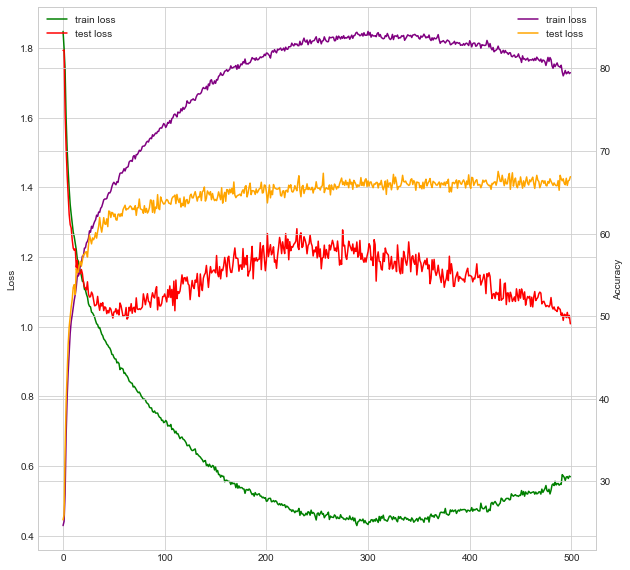

In [29]:
loss, accuracy, best_acc = multiple_epochs_cycle(500, model_1, training_dataloader, validation_dataloader, optim_cnn, criterion, scheduler_cnn, PATH, writer)

In [30]:
best_acc

0.6753970465310671

### 3.8. CNN Model Evaluation

In [31]:
PATH = "model.pt"
final_model_1 = CNN_Model()
checkpoint = torch.load(PATH)
final_model_1.load_state_dict(checkpoint['model_state_dict'])
torch.save(final_model_1, PATH)

In [32]:
final_model_1.to(device)
test_loss, test_accuracy = testing_epoch(final_model_1, testing_dataloader, criterion)
print(f'Test loss = {test_loss}, and test accuracy = {test_accuracy}')

Test loss = 1.0643532526704063, and test accuracy = 0.6701030927835051


### 3.9. Serializing the Model for Deployement

In [33]:
model_scripted = torch.jit.script(final_model_1) # Export to TorchScript
model_scripted.save('model_scripted.pt')

### 3.10. Tensorboard Plotting

In [34]:
writer.close()

In [44]:
%load_ext tensorboard

In [45]:
%tensorboard --logdir runs